In [45]:
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors, RadiusNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  # for plot styling
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure
from scipy.spatial import distance
from sklearn import metrics
from scipy.spatial.distance import cdist

%matplotlib inline

In [18]:
# Set True if you want to trace the parsing process
trace_parsing = False

# Classification algorithm parameters
BIG_RADIUS = 4
SMALL_RADIUS = 2

In [19]:
def read_model_file(filename, trace_pasing):
    coords = np.empty((0, 3))
    with open(filename) as f:
        line = f.readline()
        model_to_coords = {}
        current_model = -1
        while line:
            words = line.strip().split(' ')
            if len(words) > 0:
                if words[0] == "MODEL":
                    current_model = words[1]
                    if trace_parsing:
                        print("Current models is: MODEL", current_model)
                elif words[0] == "ATOM":
                    if current_model == -1:
                        raise NameError('Unkown model with MODEL={current_model}')
                    x, y, z = 0, 0, 0
                    coord_starts = [6, 7, 8]
                    last_nonempty = 0
                    for idx, word in enumerate(words):
                        if len(word.strip()) > 0:
                            last_nonempty += 1
                            if last_nonempty == coord_starts[0]:
                                x = word
                            elif last_nonempty == coord_starts[1]:
                                y = word
                            elif last_nonempty == coord_starts[2]:
                                z = word
                    current_model_coords = np.array([[x, y, z]])
                    if trace_parsing:
                        print(f'Atom coords for MODEL={current_model} is {current_model_coords}')
                    coords = np.append(coords, current_model_coords, axis=0)
                elif words[0] == "ENDMDL":
                    model_to_coords[int(current_model)] = coords.astype(np.float64)
                    if trace_parsing:
                        print(f'Finished MODEL={current_model}')
                    current_model = -1
            line = f.readline()
    return model_to_coords

In [20]:
def read_reslog_file(filename):
    model_to_use = []
    with open(filename) as f:
        line = f.readline()
        while line:
            words = [w for w in line.strip().split(' ') if w]
            if len(words) == 4:
                if float(words[2]) <= BIG_RADIUS:
                    model_to_use.append(int(words[0]))
            line = f.readline()
    return model_to_use

In [21]:
def calculate_model_mean(model):
    return np.mean(model, axis=0, dtype=np.float64).reshape(1, 3)

In [6]:
def calculate_centers(rootdir):
    # [(cycle_number, model_number, model_mean_vector)]
    centers = list(tuple())
    original_models = {}
    dictfilt = lambda x, y: dict([ (i,x[i]) for i in x if i in set(y) ])
    for subdir, dirs, filenames in os.walk(rootdir):
        if subdir == rootdir:
            continue
        
        print("===")
        cycle_number = os.path.relpath(subdir, "./data")
        reslog = os.path.join(subdir, [f for f in filenames if f.endswith(".log")][0])
        pdbqt = os.path.join(subdir, [f for f in filenames if f.endswith(".pdbqt")][0])
        print(f'Current directory is "{subdir}"')
        print(f'Current reslog file is "{reslog}"')
        print(f'Current model file is "{pdbqt}"')

        model_keys_to_use = read_reslog_file(reslog)
        print(f'Following models will be used {model_keys_to_use}')
        
        models_all = read_model_file(pdbqt, trace_parsing)
        models_to_use = dictfilt(models_all, model_keys_to_use)
        original_models[cycle_number] = models_to_use
        for model_key, model in models_to_use.items():
            model_mean = calculate_model_mean(model)
            centers.append((subdir, cycle_number, model_key, model, model_mean))
        print("===")
        
    return original_models, centers

In [7]:
original_models, models = calculate_centers("./data/")
for cycle_number, all_models in original_models.items():
    print("Cycle number: ", cycle_number)
    for model_number, model_coords in all_models.items():
        print("\tModel number: ", model_number)

===
Current directory is "./data/3"
Current reslog file is "./data/3/res.log"
Current model file is "./data/3/Str-2 3D_out.pdbqt"
Following models will be used [1, 2, 9, 11, 16, 19]
===
===
Current directory is "./data/2"
Current reslog file is "./data/2/res.log"
Current model file is "./data/2/Str-2 3D_out.pdbqt"
Following models will be used [1, 8, 11, 13, 16, 17]
===
===
Current directory is "./data/1"
Current reslog file is "./data/1/res.log"
Current model file is "./data/1/Str-2_3D_out.pdbqt"
Following models will be used [1, 5, 9, 12, 13, 15, 18, 20]
===
===
Current directory is "./data/5"
Current reslog file is "./data/5/res.log"
Current model file is "./data/5/Str-2 3D_out.pdbqt"
Following models will be used [1, 2, 5, 9, 12, 13, 15, 18]
===
===
Current directory is "./data/4"
Current reslog file is "./data/4/res.log"
Current model file is "./data/4/Str-2 3D_out.pdbqt"
Following models will be used [1, 2, 5, 9, 12, 13, 15, 18]
===
Cycle number:  3
	Model number:  1
	Model numbe

In [70]:
# Using NearestNeighbors
means = np.empty((0, 3))
for model in models:
    means = np.append(means, model[4], axis=0)

nneigh = NearestNeighbors(radius=BIG_RADIUS)
nneigh.fit(means)
_, indices = nneigh.radius_neighbors(means)
        
for ind, value in enumerate(indices):
    cycle, cycle_number, model_number, model, model_mean = models[ind]
    print(f'Model {model_number} from cycle {cycle} is in a cluster with:')
    for nind in value:
        print(f'\tModel {models[nind][2]} from cycle {models[nind][1]}')

Model 1 from cycle ./data/3 is in a cluster with:
	Model 1 from cycle 3
	Model 2 from cycle 3
	Model 1 from cycle 2
	Model 1 from cycle 1
	Model 1 from cycle 5
	Model 2 from cycle 5
	Model 1 from cycle 4
	Model 2 from cycle 4
Model 2 from cycle ./data/3 is in a cluster with:
	Model 1 from cycle 3
	Model 2 from cycle 3
	Model 1 from cycle 2
	Model 1 from cycle 1
	Model 1 from cycle 5
	Model 2 from cycle 5
	Model 1 from cycle 4
	Model 2 from cycle 4
Model 9 from cycle ./data/3 is in a cluster with:
	Model 9 from cycle 3
	Model 11 from cycle 3
	Model 16 from cycle 3
	Model 19 from cycle 3
	Model 8 from cycle 2
	Model 11 from cycle 2
	Model 13 from cycle 2
	Model 16 from cycle 2
	Model 17 from cycle 2
	Model 5 from cycle 1
	Model 9 from cycle 1
	Model 12 from cycle 1
	Model 13 from cycle 1
	Model 15 from cycle 1
	Model 18 from cycle 1
	Model 20 from cycle 1
	Model 9 from cycle 5
	Model 12 from cycle 5
	Model 13 from cycle 5
	Model 15 from cycle 5
	Model 18 from cycle 5
	Model 9 from cycle 

In [64]:
# Using KMeans
# Mean of the model will be used as a summary for it
means = np.empty((0, 3))
for model in models:
    means = np.append(means, model[4], axis=0)

# Elbow method to determine optimal number of the clusters
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

cluster_count = range(1, 10)

for k in cluster_count:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(means)

    distortions.append(sum(np.min(cdist(means, kmeans.cluster_centers_, 'euclidean'), axis=1)) / means.shape[0])
    inertias.append(kmeans.inertia_)
    
    mapping1[k] = sum(np.min(cdist(means, kmeans.cluster_centers_,
                                   'euclidean'), axis=1)) / means.shape[0]
    mapping2[k] = kmeans.inertia_

In [65]:
# Elbow method using distortion
for key, val in mapping1.items():
    print(f'{key} : {val}')
    
plt.plot(cluster_count, distortions, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

1 : 4.948143974382871
2 : 1.7390651580626306
3 : 1.3186745177497985
4 : 1.1381919564035303
5 : 0.982494228462981
6 : 0.8774820291974599
7 : 0.7473474394275855
8 : 0.6487205020426141
9 : 0.5807819116116089


1 : 1213.3161659240866
2 : 154.3324384343517
3 : 90.51355939459084
4 : 63.10049745564479
5 : 48.181776536642694
6 : 36.525821819466536
7 : 28.527365336741795
8 : 21.13398123151625
9 : 16.792678323112618


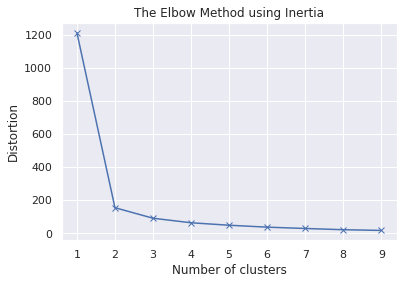

In [46]:
# Elbow method using inertias
for key, val in mapping2.items():
    print(f'{key} : {val}')
    
plt.plot(cluster_count, inertias, 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Inertia')
plt.show()

<IPython.core.display.Javascript object>


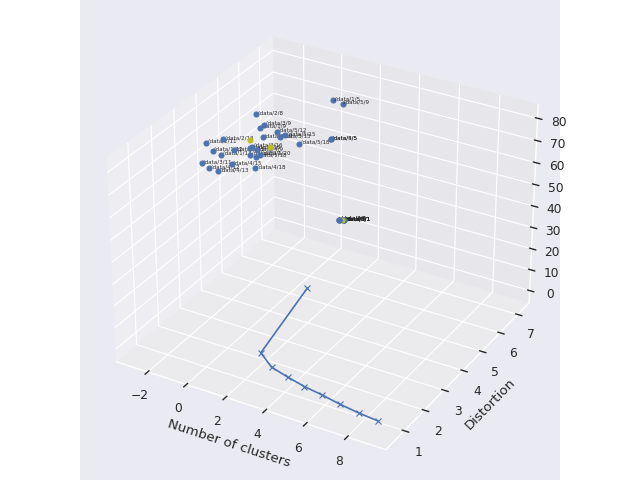

In [63]:
%matplotlib notebook
kmeans = KMeans(n_clusters=3)
kmeans.fit(means)

fig = plt.figure(figsize=(8, 6), dpi=80)
ax = Axes3D(fig, auto_add_to_figure=False)
fig.add_axes(ax)

for cycle, cycle_number, model_number, model, model_mean in models:
    ax.scatter(model_mean[:, 0], model_mean[:, 1], model_mean[:, 2], color='b')
    ax.text(float(model_mean[:, 0]), 
            float(model_mean[:, 1]),
            float(model_mean[:, 2]), '%s/%s' % (cycle, model_number), size=5)

centers = kmeans.cluster_centers_
for center in centers:
    ax.scatter(center[0], center[1], center[2], color='#bcbd22')

In [62]:
y_kmeans = kmeans.predict(means)
cluster_to_models = {}
    
for idx in range(len(models)):
    if y_kmeans[idx] in cluster_to_models:
        cluster_to_models[y_kmeans[idx]].append(models[idx])
    else:
        cluster_to_models[y_kmeans[idx]] = list()
        cluster_to_models[y_kmeans[idx]].append(models[idx])

for cluster, cmodels in cluster_to_models.items():
    print(f'Models in cluster {cluster} are: ')
    for cycle, cycle_number, model_number, model, model_mean in cmodels:
        print(f'\tFrom cycle {cycle} model {model_number}')

Models in cluster 1 are: 
	From cycle ./data/3 model 1
	From cycle ./data/3 model 2
	From cycle ./data/2 model 1
	From cycle ./data/1 model 1
	From cycle ./data/5 model 1
	From cycle ./data/5 model 2
	From cycle ./data/4 model 1
	From cycle ./data/4 model 2
Models in cluster 0 are: 
	From cycle ./data/3 model 9
	From cycle ./data/3 model 11
	From cycle ./data/3 model 16
	From cycle ./data/3 model 19
	From cycle ./data/2 model 8
	From cycle ./data/2 model 11
	From cycle ./data/2 model 13
	From cycle ./data/2 model 16
	From cycle ./data/2 model 17
	From cycle ./data/1 model 5
	From cycle ./data/1 model 9
	From cycle ./data/1 model 12
	From cycle ./data/1 model 18
	From cycle ./data/1 model 20
Models in cluster 2 are: 
	From cycle ./data/1 model 13
	From cycle ./data/1 model 15
	From cycle ./data/5 model 5
	From cycle ./data/5 model 9
	From cycle ./data/5 model 12
	From cycle ./data/5 model 13
	From cycle ./data/5 model 15
	From cycle ./data/5 model 18
	From cycle ./data/4 model 5
	From c